In [ ]:
#Process the WIDERFace dataset to create a classification dataset
import os
import numpy as np
from torchvision.datasets import WIDERFace
import torchvision.transforms.functional as trF
import torchvision.transforms as transforms

IMAGE_WIDTH = 88
IMAGE_HEIGHT = 88

dataset_path = 'dataset'
dataset_output_path = 'dataset/classification'
split_selection = 'val' # 'train' or 'val' or 'test'

dataset = WIDERFace(dataset_path, split=split_selection, download=True)
print(f"Number of images in {split_selection} dataset: {len(dataset)}")

def calculate_area_inside_crop(bbox, crop):
    x, y, w, h = bbox
    x_crop, y_crop, w_crop, h_crop = crop
    x1 = max(x, x_crop)
    y1 = max(y, y_crop)
    x2 = min(x+w, x_crop+w_crop)
    y2 = min(y+h, y_crop+h_crop)
    return max(0, x2 - x1) * max(0, y2 - y1)

# Verify that the dataset is not already processed
nb_images = -1
already_processed = True
for i in range(2):
    path = f"{dataset_output_path}/{split_selection}/{i}"
    if os.path.exists(path):
        nb_images_folder = len(os.listdir(path))
        if nb_images == -1:
            nb_images = nb_images_folder
        elif nb_images != nb_images_folder:
            already_processed = False
            break
    else:
        already_processed = False
        break
    if split_selection == 'test' :
        break

if already_processed:
    print("Dataset already processed")
else:
    for i in range(len(dataset)) :
        if (i+1) % 1000 == 0:
            print(f"Processed {i+1} images over {len(dataset)}")
        img, target = dataset[i]

        if target is None :
            invalid = [False]
            bboxes = []
        else :
            invalid = target['invalid']
            bboxes = target['bbox']
        
        nb_faces = len(bboxes)
        w_img, h_img = img.size
        
        if any(invalid): # If any face is invalid, use the image as a negative example by cropping it
            CROP_SIZE_WIDTH = 200
            CROP_SIZE_HEIGHT = 200
            if w_img < CROP_SIZE_WIDTH or h_img < CROP_SIZE_HEIGHT:
                continue
            crop_x = np.random.randint(0, w_img - CROP_SIZE_WIDTH)
            crop_y = np.random.randint(0, h_img - CROP_SIZE_HEIGHT)
            keep = 1
            for bbox in bboxes:
                area = calculate_area_inside_crop(bbox, (crop_x, crop_y, CROP_SIZE_WIDTH, CROP_SIZE_HEIGHT))
                if area > 0:
                    keep = 0
                    break
            if keep:
                img = transforms.ToTensor()(img)
                img = trF.crop(img, crop_y, crop_x, CROP_SIZE_HEIGHT, CROP_SIZE_WIDTH)
                img = trF.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
                img = trF.to_pil_image(img)
                save_path = f"{dataset_output_path}/{split_selection}/0"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                img.save(f"{save_path}/{i}.jpg")
                with open(f"{save_path}/{i}.txt", "a") as f:
                    f.write(f"{0} {0} {0} {0}\n") 
            continue

        if nb_faces > 1 : # Select only images with at most one face
            continue
        
        skip_if_too_small = False
        SMALLEST_FACE_AREA = 50
        for bbox in bboxes: # Skip images if the resized face is too small
            x, y, w, h = bbox
            area = w/w_img * h/h_img * IMAGE_HEIGHT * IMAGE_WIDTH
            if area < SMALLEST_FACE_AREA :
                skip_if_too_small = True
                break
        if skip_if_too_small:
            continue
        
        # Here we have a valid image with at most MAX_FACES faces
        img = transforms.ToTensor()(img)
        img = trF.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        img = trF.to_pil_image(img)

        # Save the image
        save_path = f"{dataset_output_path}/{split_selection}/{nb_faces}"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        img.save(f"{save_path}/{i}.jpg")
        # Save the bounding boxes
        x, y, w, h = bboxes[0]
        x = x/w_img
        y = y/h_img
        w = w/w_img
        h = h/h_img
        with open(f"{save_path}/{i}.txt", "w") as f:
            f.write(f"{int(x)} {int(y)} {int(w)} {int(h)}\n")    

    if split_selection != 'test': # Equalize the number of images in each class
        nb_images = []
        for i in range(2):
            path = f"{dataset_output_path}/{split_selection}/{i}"
            nb_images.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name)) and not name.endswith('.txt')]))

        min_images = min(nb_images)

        for i in range(2):
            path = f"{dataset_output_path}/{split_selection}/{i}"
            files = [name.split('.')[0] for name in os.listdir(path) if os.path.isfile(os.path.join(path, name)) and not name.endswith('.txt')]
            to_remove = np.random.choice(len(files), len(files) - min_images, replace=False)
            for j in to_remove:
                os.remove(f"{path}/{files[j]}.jpg")
                os.remove(f"{path}/{files[j]}.txt")

In [103]:
split_selection = 'val'

bboxes_files = [f for f in os.listdir(f"{dataset_output_path}/{split_selection}/1") if f.endswith('.txt')]

for file in bboxes_files:
    x, y, w, h = [0, 0, 0, 0]
    with open(f"{dataset_output_path}/{split_selection}/1/{file}", "r") as f:
        line = f.readline()
        x, y, w, h = [float(x) for x in line.split()]

    with open(f"{dataset_output_path}/{split_selection}/1/{file}", "w") as f:
        f.write(f"{int(x*IMAGE_WIDTH)} {int(y*IMAGE_WIDTH)} {int(w*IMAGE_WIDTH)} {int(h*IMAGE_WIDTH)}\n")
        


In [ ]:
# display image at idx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image(idx):
    img, target = dataset[idx]
    img = np.array(img)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox, valid in zip(target['bbox'], target['invalid']):
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g' if valid else 'r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

display_image(np.random.randint(len(dataset)))

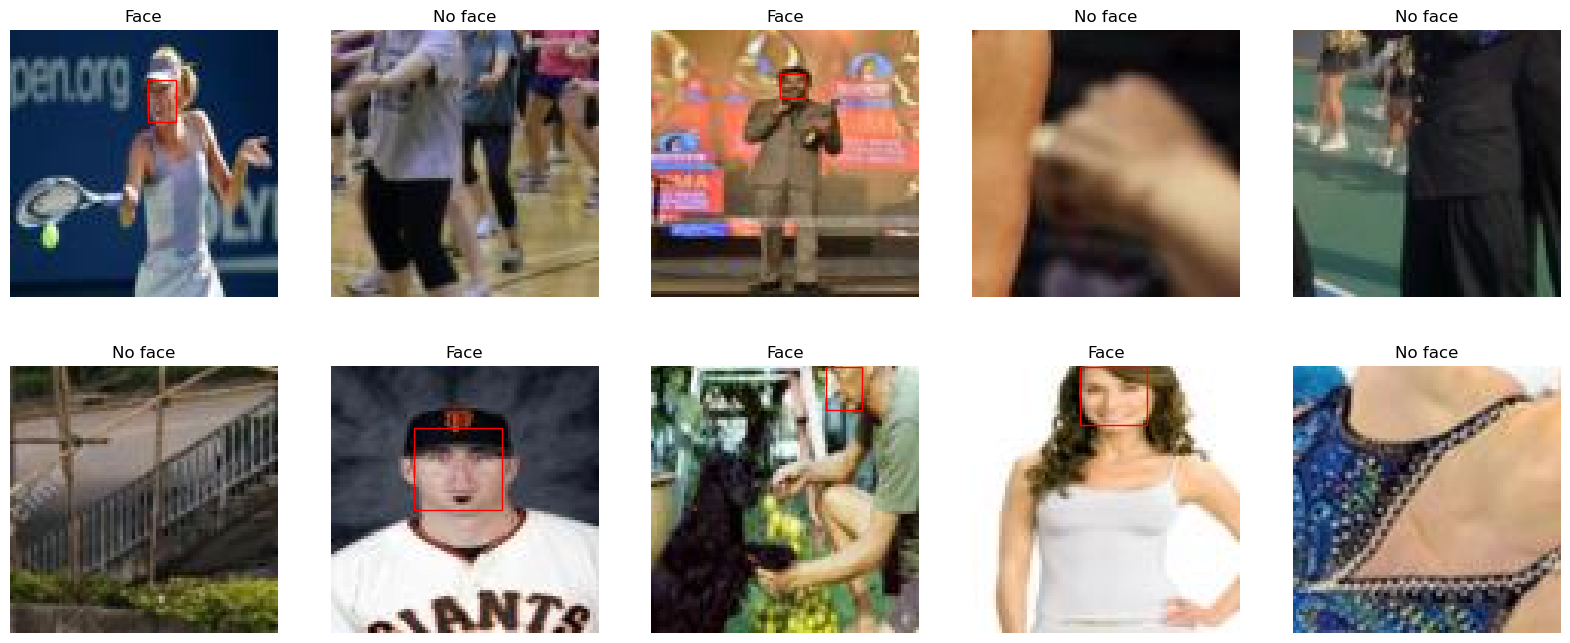

In [104]:
import torch
import torch.utils.data as data
import os
from PIL import Image

NORMALIZE_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORMALIZE_STD = torch.tensor([0.229, 0.224, 0.225])

class ClassificationDataset(data.Dataset):
    def __init__(self, root, split, transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.classes = [d.name for d in os.scandir(f"{root}/{split}") if d.is_dir()]
        self.images = []
        self.bboxes = []
        for c in self.classes :
            class_path = os.path.join(f"{root}/{split}", c)
            for path in os.listdir(class_path) :
                if path.endswith('.jpg') :
                    name = path.split('.')[0]
                    image_path = os.path.join(class_path, f"{name}.jpg")
                    self.images.append((image_path, c))
                    bbox_path = os.path.join(class_path, f"{name}.txt")
                    self.bboxes.append(bbox_path)
    
    def __getitem__(self, index):
        image_path, is_face = self.images[index]
        image = Image.open(image_path)
        image = transforms.ToTensor()(image)
        if self.transform is not None:
            image = self.transform(image)

        bbox_path = self.bboxes[index]
        if not os.path.exists(bbox_path): 
            return image, None # If there is no bounding box

        # If there is a bounding box
        target = np.zeros(5, dtype=np.float32)
        target[0] = 0 if is_face == '0' else 1
        with open(bbox_path, 'r') as f:
            line = f.readline()
            for i, x in enumerate(line.split()):
                target[i+1] = float(x)
        return image, torch.tensor(target)
        
    def __len__(self):
        return len(self.images)
    
# Load the dataset
transform = transforms.Compose([
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

train_dataset = ClassificationDataset(dataset_output_path, 'train', transform)
val_dataset = ClassificationDataset(dataset_output_path, 'val', transform)

# Display some images
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    img, target = train_dataset[np.random.randint(len(train_dataset))]
    axs[0, i].imshow((img * NORMALIZE_STD[:, None, None] + NORMALIZE_MEAN[:, None, None]).permute(1, 2, 0))
    x, y, w, h = target[1:].numpy()
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axs[0, i].add_patch(rect)
    axs[0, i].title.set_text("Face" if target[0] == 1 else "No face")
    axs[0, i].axis('off')
    img, target = val_dataset[np.random.randint(len(val_dataset))]
    axs[1, i].imshow((img * NORMALIZE_STD[:, None, None] + NORMALIZE_MEAN[:, None, None]).permute(1, 2, 0))
    x, y, w, h = target[1:].numpy()
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axs[1, i].add_patch(rect)
    axs[1, i].title.set_text("Face" if target[0] == 1 else "No face")
    axs[1, i].axis('off')

In [134]:
# Train a simple CNN
import torch.nn as nn
import torch.optim as optim
import torchsummary

dropout = 0.6

class SimpleCNN(nn.Module):
    def __init__(self, num_channels=3, dims=(IMAGE_HEIGHT, IMAGE_WIDTH)):
        super(SimpleCNN, self).__init__()
        self.h, self.w = dims
        self.c = 3
        
        self.conv1 = nn.Conv2d(num_channels, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        self.c = 16 # output channels
        self.h //= 2 # padding = 1 -> same size, pool = 2 -> half size, h = 44
        self.w //= 2 # padding = 1 -> same size, pool = 2 -> half size, w = 44

        self.conv2 = nn.Conv2d(self.c, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()
        self.c = 32 # output channels
        self.h //= 2 # padding = 1 -> same size, pool = 2 -> half size, h = 22
        self.w //= 2 # padding = 1 -> same size, pool = 2 -> half size, w = 22

        self.face1= nn.Linear(self.c * self.h * self.w, 1)
        self.face2 = nn.Sigmoid()

        self.bboxes1 = nn.Linear(self.c * self.h * self.w, 4)
        self.bboxes2 = nn.ReLU()
        
    
    def forward(self, x):
        x = self.relu1(self.pool1(self.conv1(x)))
        x = self.relu2(self.pool2(self.conv2(x)))
        x = x.view(-1, self.c * self.h * self.w)
        is_face = self.face2(self.face1(x))
        bboxes = (self.bboxes2(self.bboxes1(x)))
        x = torch.cat((is_face, bboxes), 1)
        return x

# Summarize the model
model = SimpleCNN()
torchsummary.summary(model, (3, IMAGE_HEIGHT, IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 88, 88]             448
         MaxPool2d-2           [-1, 16, 44, 44]               0
              ReLU-3           [-1, 16, 44, 44]               0
            Conv2d-4           [-1, 32, 44, 44]           4,640
         MaxPool2d-5           [-1, 32, 22, 22]               0
              ReLU-6           [-1, 32, 22, 22]               0
            Linear-7                    [-1, 1]          15,489
           Sigmoid-8                    [-1, 1]               0
            Linear-9                    [-1, 4]          61,956
             ReLU-10                    [-1, 4]               0
Total params: 82,533
Trainable params: 82,533
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 2.13
Params size (MB): 0.31
Estimated Tot

In [119]:
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define training function with progress bar
def train(model, loader, optimizer, loss_fn, epoch, num_epochs):
    model.train()
    total_loss = 0
    # Add a tqdm progress bar for training batches
    with tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False) as pbar:
        for i, (images, targets) in enumerate(pbar):
            images = images.to(device)  # Move data to correct device
            targets = targets.to(device)  # Move targets to correct device
            
            optimizer.zero_grad() # Zero the gradients
            outputs = model(images) # Forward pass

            loss = loss_fn(outputs, targets) # Compute the loss
            loss.backward()  #| Backward pass and optimization
            optimizer.step() #|

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (i + 1)) # Update the progress bar
    return total_loss / len(loader)

# Define validation function
def validate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Compute the accuracy
def accuracy(model, loader):
    correct = 0
    total = 0
    distance_to_target = 0
    area_to_target = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            predicted = outputs[:, 0] > 0.5
            total += targets.size(0)
            correct += (predicted == targets[:, 0]).sum().item()
            distance_to_target += torch.sum(torch.sqrt((outputs[:,1] - targets[:,1])**2 + (outputs[:,2] - targets[:,2])**2))
            area_to_target += torch.sum(torch.sqrt(torch.abs(outputs[:,3]*outputs[:,4] - targets[:,3]*targets[:,4])))
    return correct / total, distance_to_target / total, area_to_target / total
            

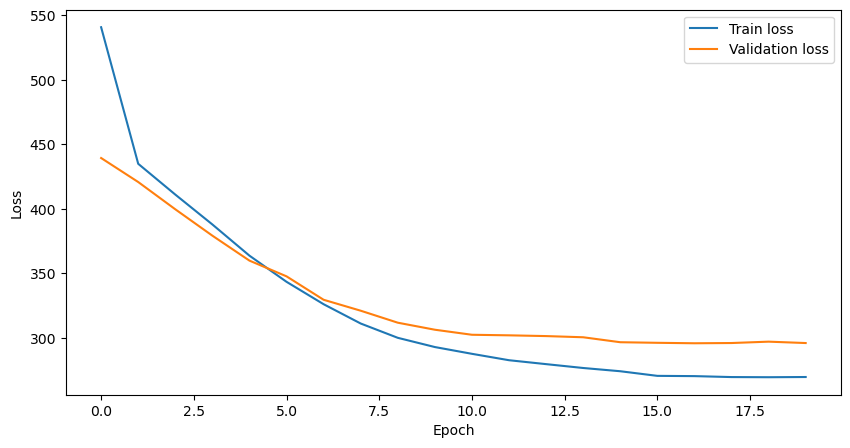

In [135]:
from torch.optim.lr_scheduler import StepLR

batch_size = 50
data_loader_train = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
data_loader_val = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR by 10 every 15 epochs

# Loss function
def loss_fn(outputs, targets):
    x_pred, y_pred, w_pred, h_pred = outputs[:, 1], outputs[:, 2], outputs[:, 3], outputs[:, 4]
    x, y, w, h = targets[:, 1], targets[:, 2], targets[:, 3], targets[:, 4]
    classification_loss = nn.BCELoss()(outputs[:, 0], targets[:, 0])
    distance_loss = nn.MSELoss()(x_pred, x) + nn.MSELoss()(y_pred, y)
    area_loss = nn.MSELoss()(torch.sqrt(w_pred), torch.sqrt(w)) + nn.MSELoss()(torch.sqrt(h_pred), torch.sqrt(h))
    return distance_loss + area_loss + classification_loss

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, data_loader_train, optimizer, loss_fn, epoch, num_epochs)
    scheduler.step()
    val_loss = validate(model, data_loader_val, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


# Save the model
models_path = "models"
model_name = "simple_cnn"
if not os.path.exists(models_path):
    os.makedirs(models_path)
torch.save(model.state_dict(), os.path.join(models_path, model_name))

In [136]:
# Load the model
models_path = "models"
model_name = "simple_cnn"
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(os.path.join(models_path, model_name)))
model.eval()

train_accuracy, train_distance_to_target, train_area_to_target = accuracy(model, data_loader_train)
val_accuracy, val_distance_to_target, val_area_to_target = accuracy(model, data_loader_val)
print(f"Accuracy - Train: {train_accuracy:.2f}, Validation: {val_accuracy:.2f}")
print(f"Distance to target - Train: {train_distance_to_target:.2f}, Validation: {val_distance_to_target:.2f}")
print(f"Area to target - Train: {train_area_to_target:.2f}, Validation: {val_area_to_target:.2f}")

/tmp/ipykernel_20601/297993825.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(models_path, model_name)))


Accuracy - Train: 0.88, Validation: 0.82
Distance to target - Train: 12.55, Validation: 13.14
Area to target - Train: 10.19, Validation: 10.34


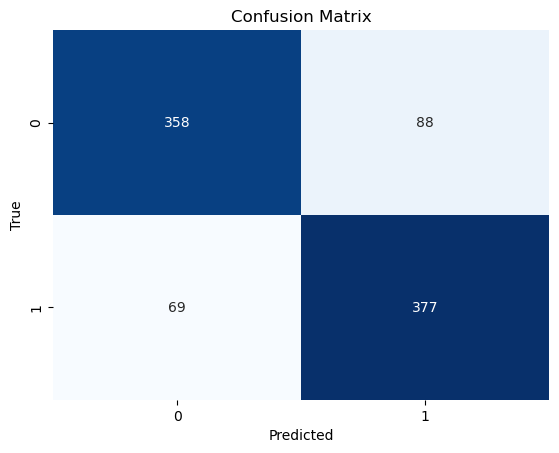

In [137]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            y_true.extend((targets[:, 0]).tolist())
            y_pred.extend((outputs[:, 0] > 0.5).tolist())

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

plot_confusion_matrix(model, data_loader_val)

[0.02269641 1.8996862  0.         0.         0.        ]
[ 0.82039464 21.30917    10.1005535   6.235114    9.809365  ]
[0.01453047 0.         0.         0.         0.        ]
[ 0.32794207 16.777658    2.5457509   1.0305302   3.4524007 ]
[ 0.88719106 30.032448    9.296342    7.771076   11.69388   ]
[ 0.19232151 11.195622    5.9134703   1.5204514   2.6864934 ]
[ 0.20498833 10.084549    3.624394    1.523892    2.1512604 ]
[ 0.92316973 24.218023   14.174305    6.0580354  10.8322115 ]
[ 0.8769794 29.815697  12.377358   7.0517464 10.756769 ]
[ 0.9952964 41.206944  17.64956   16.599684  21.943035 ]


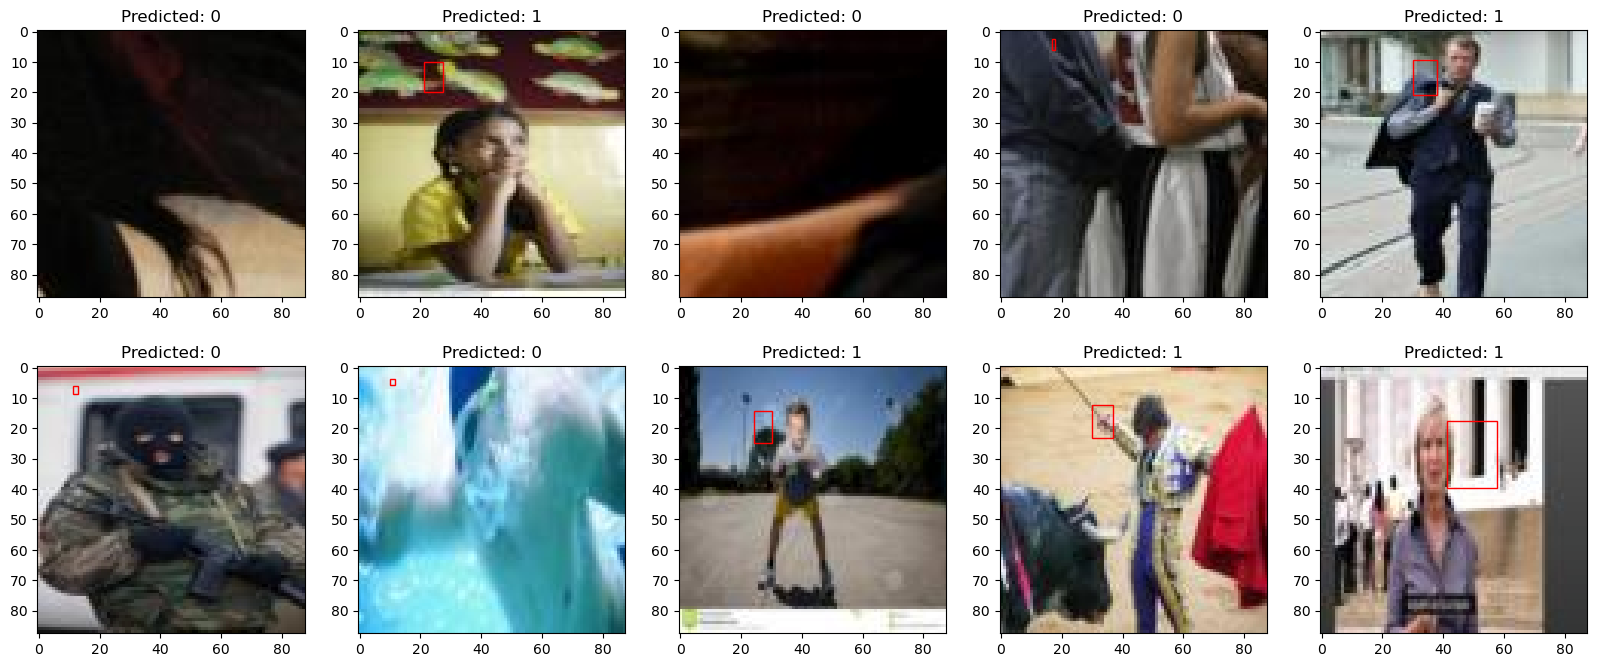

In [145]:
# Display some predictions

transform = transforms.Compose([
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])
dataset_test = ClassificationDataset(dataset_output_path, 'test', transform=transform)


fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    img, _ = train_dataset[np.random.randint(len(train_dataset))]
    output = model(img)[0].detach().numpy()
    print(output)
    predicted = output[0] > 0.5
    img = img.squeeze().cpu()
    img = (img * NORMALIZE_STD[:, None, None] + NORMALIZE_MEAN[:, None, None]).permute(1, 2, 0)
    axs[i // 5, i % 5].imshow(img)
    x, y, w, h = output[1:]
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axs[i // 5, i % 5].add_patch(rect)
    axs[i // 5, i % 5].set_title(f"Predicted: {int(predicted)}")
plt.show()